In [2]:
# ---------------- Full runnable Colab cell (copy-paste) ----------------
import random, math, time
import numpy as np





import os
multiple_device=False
# Limit this notebook to 30% compute
if multiple_device==True:
    os.environ["CUDA_MPS_ACTIVE_THREAD_PERCENTAGE"] = "40"

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import defaultdict

if multiple_device==True:
    torch.cuda.set_per_process_memory_fraction(0.4, device=0)


# ---------------- settings (tune these) ----------------
K = 100                    # number of clients
C = 0.1                    # fraction of clients per round
CLIENTS_PER_ROUND = max(1, int(math.ceil(C * K)))
ROUNDS = 200                # number of federated rounds per experiment
LOCAL_STEPS_LIST = [1, 4, 8, 16]
BASE_J = 4
CLIENT_BATCH = 16
EMB_DIM = 32
HIDDEN_DIM = 128
LR_LOCAL = 1e-3
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAMMAS = [0.01, 0.1, 1.0, 10.0]  # dirichlet concentration values for skewed scheme
log_every = 1      # print participation summary every `log_every` rounds
topk = 5

# ----------------------------------------------------------------------

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---------------- load dataset & build vocab ----------------
def iid_shards_by_chunk_indices(dataset_len, num_clients=100, seed=42):
    idxs = list(range(dataset_len))
    random.Random(seed).shuffle(idxs)
    shards = [[] for _ in range(num_clients)]
    for i, idx in enumerate(idxs):
        shards[i % num_clients].append(idx)
    return shards
if "train_ds" not in globals() or "val_ds" not in globals() or "test_ds" not in globals():
    print("Loading Shakespeare dataset (this may take a few seconds)...")
    hf = load_dataset("flwrlabs/shakespeare", split="train").shuffle(seed=SEED)
   


    # train/val split
    parts = hf.train_test_split(test_size=0.1, seed=SEED)  # 10% for val+test
    train_hf = parts['train']

    # split the 10% leftover into val and test (50-50)
    val_test_hf = parts['test'].train_test_split(test_size=0.5, seed=SEED)
    val_hf = val_test_hf['train']
    test_hf = val_test_hf['test']

    # build vocab from training split
    chars = sorted({c for txt in train_hf['x'] for c in txt} | set(train_hf['y']))
    PAD_TOKEN = "<pad>"
    vocab = [PAD_TOKEN] + chars
    char2idx = {c: i for i, c in enumerate(vocab)}
    idx2char = {i: c for c, i in char2idx.items()}
    VOCAB_SIZE = len(vocab)
    print(f"Train size: {len(train_hf)}, Val size: {len(val_hf)}, Vocab size: {VOCAB_SIZE}")

    # dataset wrapper
    class ShakespeareDataset(Dataset):
        def __init__(self, hf_dataset, char2idx):
            self.hf = hf_dataset
            self.char2idx = char2idx
        def __len__(self):
            return len(self.hf)
        def __getitem__(self, idx):
            item = self.hf[int(idx)]
            x_str, y_str = item['x'], item['y']
            x_idx = torch.tensor([self.char2idx[ch] for ch in x_str], dtype=torch.long)
            y_idx = torch.tensor(self.char2idx[y_str], dtype=torch.long)
            return x_idx, y_idx

    train_ds = ShakespeareDataset(train_hf, char2idx)
    val_ds = ShakespeareDataset(val_hf, char2idx)
        # wrap test dataset
    test_ds = ShakespeareDataset(test_hf, char2idx)

    
else:
    print("Shakespeare dataset already loaded; skipping reload.")


# ---------------- model definition ----------------
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, emb=EMB_DIM, hid=HIDDEN_DIM, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb, hid, batch_first=True)
        self.fc = nn.Linear(hid, vocab_size)
    def forward(self, x):
        e = self.embed(x)
        out, _ = self.lstm(e)
        return self.fc(out[:, -1, :])

# ---------------- evaluate helper ----------------
def evaluate(model, dataset, device=DEVICE, batch_size=256):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0; total = 0; correct = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss / total, correct / total


Loading Shakespeare dataset (this may take a few seconds)...
Train size: 3803542, Val size: 211308, Vocab size: 80


kk

=== Experiment: uniform_J4 | rounds=500, local_steps=4 ===
Resuming from checkpoint_shakespeare/gamma_uniform_nc_1_J_4_round_500.pth
Resuming at round 501
Finished uniform_J4 in 0.0s  final_val_acc=0.1047


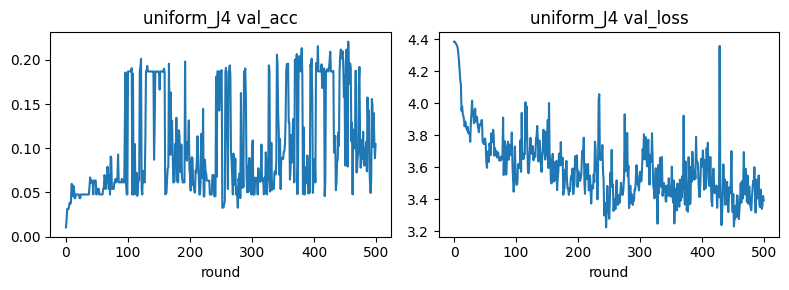


=== Experiment: uniform_J8 | rounds=250, local_steps=8 ===
Resuming from checkpoint_shakespeare/gamma_uniform_nc_1_J_8_round_250.pth
Resuming at round 251
Finished uniform_J8 in 0.0s  final_val_acc=0.0433


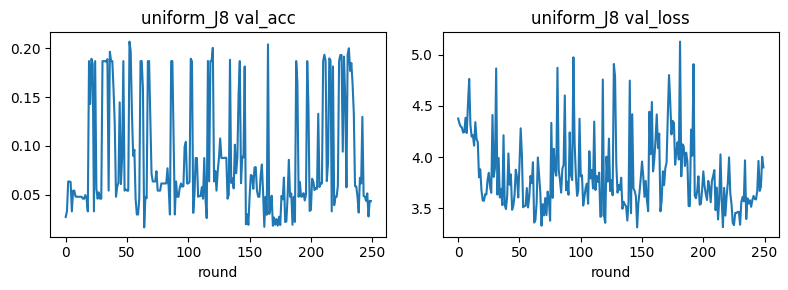


=== Experiment: uniform_J16 | rounds=125, local_steps=16 ===
Resuming from checkpoint_shakespeare/gamma_uniform_nc_1_J_16_round_125.pth
Resuming at round 126
Finished uniform_J16 in 0.0s  final_val_acc=0.0148


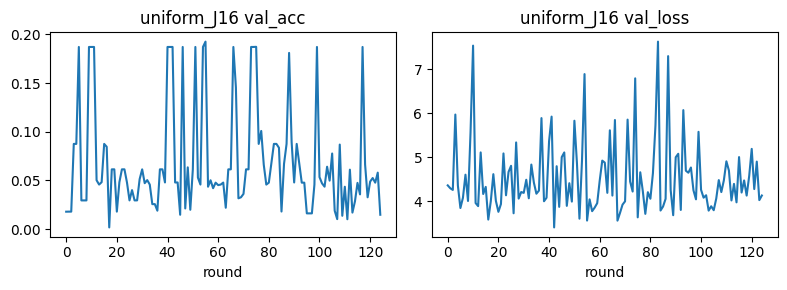

In [ ]:
import csv
import os
import json
from tqdm import tqdm
# ---------------- client local update (expects dataset returning (x_tensor,y_tensor)) ----------------
def client_update(global_state, client_idx_list, train_dataset, steps, batch_size=CLIENT_BATCH, lr=LR_LOCAL, device=DEVICE):
    """
    Local client training starting from global_state.
    Returns (state_cpu_dict, num_examples).
    Assumes train_dataset[i] returns (x_tensor, y_tensor).
    """
    if len(client_idx_list) == 0:
        return None, 0

    # DataLoader for this client's subset
    subset = Subset(train_dataset, client_idx_list)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

    # local model init
    local_model = CharLSTM(VOCAB_SIZE).to(device)
    local_model.load_state_dict(global_state)
    opt = optim.Adam(local_model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    it = iter(loader)
    steps_done = 0
    while steps_done < steps:
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(loader)
            xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = local_model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=1.0)
        opt.step()
        steps_done += 1

    state_cpu = {k: v.cpu().clone() for k, v in local_model.state_dict().items()}
    return state_cpu, len(client_idx_list)

# ---------------- aggregation helper ----------------
def aggregate_states(local_states, local_sizes):
    """Weighted average of CPU state dicts."""
    new_state = {}
    total = float(sum(local_sizes))
    keys = local_states[0].keys()
    for k in keys:
        new_state[k] = torch.zeros_like(local_states[0][k], dtype=local_states[0][k].dtype)
        for s, sz in zip(local_states, local_sizes):
            new_state[k] += s[k] * (sz / total)
    return new_state

# ---------------- sampling function (Dirichlet skew) ----------------
def sample_skewed_clients(K, C, gamma):
    """
    Draw Dirichlet probabilities and sample clients without replacement.
    Defensively handles numerical issues by falling back to uniform p if needed.
    Returns (selected_list, pvec)
    """
    if gamma is None or not (isinstance(gamma, (int, float)) and gamma > 0):
        raise ValueError("gamma must be a positive float for skewed sampling")

    p = np.random.dirichlet([gamma] * K)
    # defensive normalization / fallback
    if np.isnan(p).any() or p.sum() == 0:
        p = np.ones(K) / K
    else:
        p = p / p.sum()

    num_sel = max(1, int(math.ceil(C * K)))
    selected = list(np.random.choice(np.arange(K), size=num_sel, replace=False, p=p))
    return selected, p

# ---------------- optional: non-iid shard creator (by target label count Nc) ----------------
def create_label_shards(train_dataset, idx2char, K, Nc, seed=SEED):
    """
    Create client shards where each client has at most Nc distinct target labels.
    Returns client_indices list-of-lists and clients_allowed (labels per client).
    """
    random.seed(seed)
    all_labels = list(idx2char.values())  # char list
    clients_allowed = []
    for k in range(K):
        allowed = random.sample(all_labels, min(Nc, len(all_labels)))
        clients_allowed.append(set(allowed))

    # Ensure each label appears at least once
    label_to_clients = defaultdict(list)
    for k, labels in enumerate(clients_allowed):
        for lab in labels:
            label_to_clients[lab].append(k)
    for lab in all_labels:
        if len(label_to_clients[lab]) == 0:
            k = random.randrange(K)
            clients_allowed[k].add(lab)
            label_to_clients[lab].append(k)

    # assign examples to clients that have that label in their allowed set
    client_indices = [[] for _ in range(K)]
    for i in range(len(train_dataset)):
        _, y = train_dataset[i]
        label_char = idx2char[int(y.item())]
        eligible = label_to_clients[label_char]
        chosen = random.choice(eligible)
        client_indices[chosen].append(i)
    return client_indices, clients_allowed


def create_label_shards_by_role(train_dataset, K, Nc, seed=SEED):
    print("kk")

    play_titles =     ['ALLS_WELL_THAT_ENDS_WELL', 'AS_YOU_LIKE_IT', 'THE_COMEDY_OF_ERRORS', 'LOVE_S_LABOUR_S_LOST', 'MEASURE_FOR_MEASURE', 'THE_MERCHANT_OF_VENICE', 'THE_MERRY_WIVES_OF_WINDSOR', 'A_MIDSUMMER_NIGHT_S_DREAM', 'MUCH_ADO_ABOUT_NOTHING', 'THE_TRAGEDY_OF_HAMLET__PRINCE_OF_DENMARK', 'THE_TAMING_OF_THE_SHREW', 'THE_TEMPEST', 'TWELFTH_NIGHT__OR__WHAT_YOU_WILL', 'THE_TWO_GENTLEMEN_OF_VERONA', 'THE_WINTER_S_TALE', 'KING_JOHN', 'SECOND_PART_OF_KING_HENRY_IV', 'THE_LIFE_OF_KING_HENRY_THE_FIFTH', 'THE_FIRST_PART_OF_KING_HENRY_THE_FOURTH', 'THE_FIRST_PART_OF_HENRY_THE_SIXTH', 'THE_SECOND_PART_OF_KING_HENRY_THE_SIXTH', 'THE_THIRD_PART_OF_KING_HENRY_THE_SIXTH', 'KING_RICHARD_THE_SECOND', 'KING_RICHARD_III', 'KING_HENRY_THE_EIGHTH', 'THE_TRAGEDY_OF_ANTONY_AND_CLEOPATRA', 'THE_TRAGEDY_OF_CORIOLANUS', 'CYMBELINE', 'THE_TRAGEDY_OF_JULIUS_CAESAR', 'THE_TRAGEDY_OF_KING_LEAR', 'THE_TRAGEDY_OF_MACBETH', 'THE_TRAGEDY_OF_OTHELLO__MOOR_OF_VENICE', 'THE_TRAGEDY_OF_ROMEO_AND_JULIET', 'THE_LIFE_OF_TIMON_OF_ATHENS', 'THE_TRAGEDY_OF_TITUS_ANDRONICUS', 'THE_HISTORY_OF_TROILUS_AND_CRESSIDA']

    


    role_index_map = {}
    for idx, r in enumerate(train_dataset.hf["character_id"]):
        match = next((title for title in play_titles if r.startswith(title)), None)
        if match:
            stripped=r[len(match):].lstrip("_")
            if(stripped.startswith("OR__WHAT_YOU_WILL")):   
                print("match", match)
   
        
            if stripped not in role_index_map:
                role_index_map[stripped] = []
            role_index_map[stripped].append(idx)
        else:
            raise ValueError(f"Role '{r}' does not start with any known play title.")
    

    sorted_roles = sorted(role_index_map.keys(), key=lambda r: len(role_index_map[r]), reverse=True)

    # 3. Assign roles to clients round-robin until each client has Nc classes
    clients_allowed = [set() for _ in range(K)]
    client_ptr = 0
    num_roles = len(sorted_roles)
    role_idx = 0
    while not all(len(c) >= Nc for c in clients_allowed):
        role = sorted_roles[role_idx % num_roles]  # cycle through roles if needed

        # assign role only if client still needs roles
        if len(clients_allowed[client_ptr]) < Nc:
            clients_allowed[client_ptr].add(role)

    # move to next client
        client_ptr = (client_ptr + 1) % K
        role_idx += 1

        
    # 4. Build reverse mapping role → eligible clients
    role_to_clients = defaultdict(list)
    for k, roles in enumerate(clients_allowed):
        for role in roles:
            role_to_clients[role].append(k)

    # 5. Assign dataset indices to clients
    client_indices = [[] for _ in range(K)]
    for role, indices in role_index_map.items():
        if role not in role_to_clients:
            continue  # skip if role not assigned
        eligible = role_to_clients[role]
        for client_id in eligible:
            client_indices[client_id].extend(indices)

    
    rng = random.Random(seed)
    
    for client_list in client_indices:
        rng.shuffle(client_list)

    return client_indices, clients_allowed





# ---------------- main experiment loop: uniform vs skewed ----------------


def run_global(
    J,
      shards,
    gamma="uniform",        # "uniform" or float
    K=K,
    C=C,
    rounds_global=ROUNDS,
    client_batch=CLIENT_BATCH,
    lr_local=LR_LOCAL,
    device=DEVICE,
    log_every=log_every,
    name="shakespeare",
    topk=topk,
    plot=True
):
    """
    Run FedAvg with a single gamma and local steps J.

    Args:
        J (int): Number of local steps per client.
        gamma (str|float): "uniform" for uniform sampling, or positive float for skewed sampling.
        plot (bool): Whether to plot validation metrics and selection counts.

    Returns:
        dict: Results dictionary with losses, accuracies, selection counts, etc.
    """
    # check gamma validity
    if gamma != "uniform" and not (isinstance(gamma, (int, float)) and gamma > 0):
        raise ValueError("gamma must be 'uniform' or a positive float")

    # rounds adjusted to keep total local updates ~ constant
   
    scheme_name = f"uniform_J{J}" if gamma == "uniform" else f"skewed_gamma{gamma}_J{J}"

    print(f"\n=== Experiment: {scheme_name} | rounds={rounds_global}, local_steps={J} ===")

    # fresh global model
    global_model = CharLSTM(VOCAB_SIZE).to(device)
    global_state = global_model.state_dict()
    val_losses, val_accs = [], []
    sel_counts = np.zeros(K, dtype=int)
    pvec = None





    ckpt_dir="checkpoint_shakespeare"
    os.makedirs(ckpt_dir, exist_ok=True)
    start_round=1


    ckpt_files = [f for f in os.listdir(ckpt_dir) if f.startswith(f"{name}_round_")]
    if ckpt_files:
            latest = max(ckpt_files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
            resume_ckpt = os.path.join(ckpt_dir, latest)
            print(f"Resuming from {resume_ckpt}")
            ckpt = torch.load(resume_ckpt, map_location=device, weights_only=False)

            # restore model
            global_model.load_state_dict(ckpt["model_state"])
            global_state = global_model.state_dict()

            # restore histories
            val_losses = ckpt["val_losses"]
            val_accs = ckpt["val_accs"]
            sel_counts = np.array(ckpt["sel_counts"])
            pvec = ckpt["pvec"]

            # restore RNG states
            rng_state = ckpt["rng_state"]
            if isinstance(rng_state, torch.ByteTensor):
                rng_state = rng_state.clone().detach().cpu()
            else:
                rng_state = torch.as_tensor(rng_state, dtype=torch.uint8, device="cpu")
            torch.set_rng_state(rng_state)

            if torch.cuda.is_available() and ckpt.get("cuda_rng_state") is not None:
                cuda_states = []
                for s in ckpt["cuda_rng_state"]:
                    if isinstance(s, torch.ByteTensor):
                        s = s.clone().detach().cpu()
                    else:
                        s = torch.as_tensor(s, dtype=torch.uint8, device="cpu")
                    cuda_states.append(s)
                torch.cuda.set_rng_state_all(cuda_states)

            # figure out resume round
            start_round = int(latest.split("_")[-1].split(".")[0]) + 1
            print(f"Resuming at round {start_round}")

    t0 = time.time()
    for r in range(start_round, rounds_global + 1):
        # --- client sampling ---
        if gamma == "uniform":
            selected = random.sample(range(K), CLIENTS_PER_ROUND)
            pvec = np.ones(K) / K
        else:
            selected, pvec = sample_skewed_clients(K, C, gamma)
            if pvec is None or np.isnan(pvec).any() or pvec.sum() == 0:
                pvec = np.ones(K) / K
                selected = random.sample(range(K), CLIENTS_PER_ROUND)

        for s in selected:
            sel_counts[s] += 1

        # --- logging ---
        """if (r % log_every) == 0:
            #p_min, p_max, p_sum = float(np.min(pvec)), float(np.max(pvec)), float(np.sum(pvec))
             selected
            print(f"[{scheme_name}] Round {r}/{rounds_global}  p_min={p_min:.4e}, p_max={p_max:.4e}, p_sum={p_sum:.4f}")
            print("  selected this round (first 20):", selected[:20], f"(total={len(selected)})")
            print("-" * 60) """

        # --- local updates ---
        local_states, local_sizes = [], []
        for cid in selected:
            idx_list = shards[cid]
            if len(idx_list) == 0:
                continue
            s_state, s_size = client_update(global_state, idx_list, train_ds,
                                            steps=J, batch_size=client_batch, lr=lr_local, device=device)
            if s_state is None:
                continue
            local_states.append(s_state)
            local_sizes.append(s_size)

        # --- aggregation ---
        if len(local_states) > 0:
            new_state = aggregate_states(local_states, local_sizes)
            global_state = {k: new_state[k].to(device) for k in new_state}
            global_model.load_state_dict(global_state)
        else:
            print("Warning: no client contributions this round; skipping aggregation.")

        # --- evaluation ---
        val_loss, val_acc = evaluate(global_model, val_ds, device=device)
        test_loss, test_acc = evaluate(global_model, test_ds, device=device)

        # train acc/loss only every 10 rounds
        if r % 10 == 0:
            train_loss, train_acc = evaluate(global_model, train_ds, device=device)
        else:
            train_loss, train_acc = -1, -1

        csv_path=f'./shakespeare_with_name.csv'

        #csv_path_res = f'./'+name+'_results.csv'
        if not os.path.exists(csv_path):
            with open(csv_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['name','round',"sel_counts", 'val_loss', 'val_acc', 'test_loss', 'test_acc','train_loss', 'train_acc'])


        with open(csv_path, 'a', newline='') as f:
            csv.writer(f).writerow([
                name,
                r,
                json.dumps(sel_counts.tolist()),

                f"{val_loss:.4f}", f"{val_acc:.4f}",
                f"{test_loss:.4f}", f"{test_acc:.4f}",
                 f"{train_loss:.4f}",  f"{train_acc:.4f}"
            ])

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        save_every=25


        if (r % save_every == 0) or (r == rounds_global):
            ckpt = {
                "round": r,
                "model_state": global_model.state_dict(),
                "val_losses": val_losses,
                "val_accs": val_accs,
                "sel_counts": sel_counts.tolist(),
                "pvec": pvec,
                "rng_state": torch.get_rng_state(),
                "cuda_rng_state": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
                "gamma": gamma,
                "J": J
            }
            ckpt_path = os.path.join(ckpt_dir, f"{name}_round_{r}.pth")
            torch.save(ckpt, ckpt_path)
            print(f"Saved checkpoint -> {ckpt_path}")
            for f in os.listdir(ckpt_dir):
                if f.startswith(f"{name}_round_") and f.endswith(".pth"):
                    f_path = os.path.join(ckpt_dir, f)
                    if f_path != ckpt_path:
                        os.remove(f_path)
                        print(f"Deleted old checkpoint {f_path}")

        if r % max(1, rounds_global // 5) == 0 or r in [1, rounds_global]:
            print(f"[{scheme_name}] Round {r}/{rounds_global}  val_acc={val_acc:.4f}  val_loss={val_loss:.4f}")

    elapsed = time.time() - t0
    print(f"Finished {scheme_name} in {elapsed:.1f}s  final_val_acc={val_accs[-1]:.4f}")

    # --- save results ---
    results = {
        'rounds': rounds_global,
        'J': J,
        'gamma': gamma,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'sel_counts': sel_counts,
        'pvec_last_round': pvec,
        'time_s': elapsed
    }

    # --- plotting ---
    if plot:
        plt.figure(figsize=(8,3))
        plt.subplot(1,2,1); plt.plot(val_accs); plt.title(f"{scheme_name} val_acc"); plt.xlabel('round')
        plt.subplot(1,2,2); plt.plot(val_losses); plt.title(f"{scheme_name} val_loss"); plt.xlabel('round')
        plt.tight_layout(); plt.show()

        if gamma != "uniform":
            plt.figure(figsize=(8,3))
            plt.bar(np.arange(K), sel_counts)
            plt.title(f"Selection counts per client ({scheme_name})")
            plt.xlabel("client id"); plt.ylabel("times selected")
            plt.show()

    return results




    
results = {}
device = DEVICE
round_base=500
schemes = ['uniform', 'skewed']

GAMMAS= [ "uniform"] 
LOCAL_STEPS_LIST = [4,8,16]



for nc in [1]:
                    # IID shards
    if nc=="iid":

        shards = iid_shards_by_chunk_indices(len(train_ds), num_clients=K, seed=SEED)
    
    else:
                    

        shards,realNc=create_label_shards_by_role(train_ds, K, nc, seed=SEED)

    for gamma in GAMMAS:

            for J in LOCAL_STEPS_LIST:

                
                global_rounds = max(1, math.ceil((round_base * 4) / float(J)))
                res_uniform = run_global(name=f"split_by_role_gamma_{str(gamma)}_nc_{str(nc)}_J_{J}",J=J, gamma=gamma,rounds_global=global_rounds,shards=shards)

